<a href="https://colab.research.google.com/github/bnarath/VariationalAutoEncoder_MNIST/blob/main/MNIST_VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#To check if GPU is running
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



# Reference

https://github.com/spmallick/learnopencv/blob/master/Variational-Autoencoder-TensorFlow/VAE_FashionMnist_TensorFlow.ipynb

# Libraries

In [2]:
import tensorflow as tf
# from IPython import display
import matplotlib.pyplot as plt
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend as K
import os
import time

# Mount gdrive

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [4]:
path = '/content/gdrive/MyDrive/VAE'

# Load MNIST

In [5]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

In [6]:
# We do not need labels
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1).astype('float32')
x_train = x_train / 255.

x_test = x_test.astype('float32')
x_test = x_test / 255.

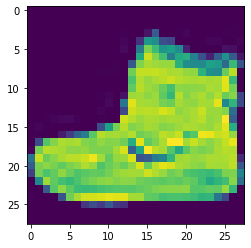

In [7]:
plt.imshow(x_train[0].reshape(28,28))

In [8]:
bs = 128
train_ds = tf.data.Dataset.from_tensor_slices(x_train).\
shuffle(x_train.shape[0]).\
batch(bs)

# Define Encoder Network

In [9]:
def encoder(input_shape):
#   Here we define the encoder network which takes an input of size [None, 28, 28, 1]. There are a total of four Conv blocks each consisting of a Conv2D, BatchNorm and LeakyReLU activation function. In each block, the image is downsampled by a factor of two. The slope of LeakyReLU is by default 0.2.

# In the final block or the Flatten layer we convert the [None, 7, 7, 64] to a vector of size 3136.

# Pay attention to Lines 48-49 since this is where we define mean and log_variance vectors. These two vectors are also known as latent-variables. The output of the model will be passed to the sampling network. The Network ( encoder ) learns to map the data ( Fashion-MNIST ) to two latent variables ( mean & variance vectors ) that are expected to follow a normal distribution.

  inputs = tf.keras.Input(shape=input_shape, name='input_layer')

  #Block1
  x = layers.Conv2D(filters=32, kernel_size=3, strides=1, padding='same', name='Block1_conv_layer')(inputs)
  x = layers.BatchNormalization(name='Block1_batchnorm')(x)
  x = layers.LeakyReLU(name = 'Block1_lrelu_layer')(x)

  #Block2
  x = layers.Conv2D(filters=64, kernel_size=3, strides=2, padding='same', name='Block2_conv_layer')(x)
  x = layers.BatchNormalization(name='Block2_batchnorm')(x)
  x = layers.LeakyReLU(name = 'Block2_lrelu_layer')(x)

  #Block3
  x = layers.Conv2D(filters=64, kernel_size=3, strides=2, padding='same', name='Block3_conv_layer')(x)
  x = layers.BatchNormalization(name='Block3_batchnorm')(x)
  x = layers.LeakyReLU(name = 'Block3_lrelu_layer')(x)

  #Block4
  x = layers.Conv2D(filters=64, kernel_size=3, strides=1, padding='same', name='Block4_conv_layer')(x)
  x = layers.BatchNormalization(name='Block4_batchnorm')(x)
  x = layers.LeakyReLU(name = 'Block4_lrelu_layer')(x)

  #Final Block
  flatten = layers.Flatten()(x)
  mean = layers.Dense(2, name='Zmean')(flatten)
  log_var = layers.Dense(2, name='log_Zvar')(flatten)

  #model
  model = tf.keras.Model(inputs, (mean, log_var), name='Encoder')

  return model


In [10]:
input_shape = (28, 28, 1)
enc = encoder(input_shape)

In [11]:
enc.output

(<KerasTensor: shape=(None, 2) dtype=float32 (created by layer 'Zmean')>,
 <KerasTensor: shape=(None, 2) dtype=float32 (created by layer 'log_Zvar')>)

# Sampling Network

In [12]:
def sampling(IN1, IN2):
  mean = tf.keras.Input(shape=IN1, name='sampling_input_layer1')
  log_var = tf.keras.Input(shape=IN2, name='sampling_input_layer2')
  out = layers.Lambda(sampling_reparameterization, name='sampling_output_Z')([mean, log_var])
  sampling_model = tf.keras.Model([mean, log_var], out, name="sampling_model")
  return sampling_model

In [13]:
def sampling_reparameterization(distribution_params):
  mean, log_var = distribution_params
  eps = K.random_normal(shape=K.shape(mean), mean=0., stddev=1.)
  Z = mean + K.exp(log_var/2)*eps
  return Z

In [14]:
input_1 = (2,)
input_2 = (2,)
sample = sampling(input_1,input_2)

# Decoder Network

In [15]:
def decoder(input_decoder_shape):

# The decoder network of the variational autoencoder is exactly similar to a vanilla autoencoder. It takes an input of size [None, 2]. The initial block has a Dense layer having 3136 neurons, recall in the encoder function this was the size of the vector after flattening the output from the last conv block. There are a total of four Conv blocks. The Conv block [1, 3] consists of a Conv2DTranspose, BatchNorm and LeakyReLU activation function. The Conv block 4 has a Conv2DTranspose with sigmoid activation function, which squashes the output in the range [0, 1] since the images are normalized in that range. In each block, the image is upsampled by a factor of two.

# The output from the decoder network is a tensor of size [None, 28, 28, 1].

  inputs = tf.keras.Input(shape=input_decoder_shape, name='input_decoder')
  x = layers.Dense(3136, name='Decoder_dense')(inputs)
  x = layers.Reshape((7,7,64), name='Decoder_Reshape_Layer')(x)

  #Block1
  x = layers.Conv2DTranspose(filters=64, kernel_size=3, strides=1, padding='same', name='Block1_conv_transpose_layer')(x)
  x = layers.BatchNormalization(name='Block1_decoder_batchnorm')(x)
  x = layers.LeakyReLU(name = 'Block1_decoder_lrelu_layer')(x)

  #Block2
  x = layers.Conv2DTranspose(filters=64, kernel_size=3, strides=2, padding='same', name='Block2_conv_transpose_layer')(x)
  x = layers.BatchNormalization(name='Block2_decoder_batchnorm')(x)
  x = layers.LeakyReLU(name = 'Block2_decoder_lrelu_layer')(x)

  #Block3
  x = layers.Conv2DTranspose(filters=32, kernel_size=3, strides=2, padding='same', name='Block3_conv_transpose_layer')(x)
  x = layers.BatchNormalization(name='Block3_decoder_batchnorm')(x)
  x = layers.LeakyReLU(name = 'Block3_decoder_lrelu_layer')(x)

  #Block4
  output = layers.Conv2DTranspose(filters=1, kernel_size=3, strides=1, padding='same', activation='sigmoid', name='Block4_conv_transpose_layer')(x)

  #model
  model = tf.keras.Model(inputs, output, name='Decoder')

  return model

In [16]:
input_decoder_shape = (2,)
dec = decoder(input_decoder_shape)

# Optimizer and Loss Function

In [17]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)

def mse_loss(y_true, y_pred):
  r_loss = K.mean(K.square(y_true-y_pred), axis=[1,2,3])
  return 1000*r_loss

def kl_loss(mean, log_var):
    kl_loss =  -0.5 * K.sum(1 + log_var - K.square(mean) - K.exp(log_var), axis = 1)
    return kl_loss

def vae_loss(y_true, y_pred, mean, var):
    r_loss = mse_loss(y_true, y_pred)
    klloss = kl_loss(mean, var)
    return  r_loss + klloss


# Training the Variational Autoencoder

In [18]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
  #GradientTape records the computation and provides the automatic differenciation
  with tf.GradientTape() as E, tf.GradientTape() as D:
       mean, log_var = enc(images, training=True)
       latent = sample([mean, log_var])
       generated_images = dec(latent, training=True)
       loss = vae_loss(images, generated_images, mean, log_var)

  gradients_of_enc = E.gradient(loss, enc.trainable_variables)
  gradients_of_dec = D.gradient(loss, dec.trainable_variables)

  optimizer.apply_gradients(zip(gradients_of_enc, enc.trainable_variables))
  optimizer.apply_gradients(zip(gradients_of_dec, dec.trainable_variables))
  return loss



# Training

In [19]:
os.makedirs(os.path.join(path, 'MNIST/training_weights'), exist_ok=True)
os.makedirs(os.path.join(path, 'MNIST/images'), exist_ok=True)

In [20]:
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()
        i = 0
        loss_ = []
        for image_batch in dataset:
            i += 1
            loss = train_step(image_batch)
            #loss_.append(loss)

        #print("Loss",np.mean(loss_))    
        test = image_batch[:25]
        # display.clear_output(wait=True)
        generate_and_save_images([enc,sample,dec],
                                  epoch + 1,
                                  test)
        # Save the model every 15 epochs
        #if (epoch + 1) % 15 == 0:
        #checkpoint.save(file_prefix = checkpoint_prefix)
        enc.save_weights(os.path.join(path, 'MNIST/training_weights', 'enc_'+ str(epoch)+'.h5'))
        dec.save_weights(os.path.join(path, 'MNIST/training_weights', 'dec_'+ str(epoch)+'.h5'))
        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

        # Generate after the final epoch
    # display.clear_output(wait=True)
    generate_and_save_images([enc,sample,dec],
                            epochs,
                            test)

In [21]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
    m, v = enc(test_input, training=False)
    latent = sample([m,  v])
    predictions = dec(latent, training=False)
    print(predictions.shape)
    fig = plt.figure(figsize=(4,4))

    for i in range(predictions.shape[0]):
        plt.subplot(5, 5, i+1)
        plt.imshow(predictions[i, :, :, 0] * 255, cmap='gray')
        plt.axis('off')

    plt.savefig(os.path.join(path, 'MNIST/images', 'image_at_epoch_{:d}.png'.format(epoch)))
    plt.show()

In [22]:
# def train(dataset, epochs):
#   for epoch in range(epochs):
#     start = time.time()
#     for batch in dataset:
#       train_step(batch)
#       print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

# train(train_ds, 100)


In [23]:
# train(train_ds, 100)

# Reconstructing the test images

In [26]:
# Restore the loaded weights
enc.load_weights(os.path.join(path, 'MNIST/training_weights', 'enc_99.h5'), by_name=True)
dec.load_weights(os.path.join(path, 'MNIST/training_weights', 'dec_99.h5'), by_name=True)

In [27]:
# Create dictionary of target classes
label_dict = {
 0: 'T-shirt/top',
 1: 'Trouser',
 2: 'Pullover',
 3: 'Dress',
 4: 'Coat',
 5: 'Sandal',
 6: 'Shirt',
 7: 'Sneaker',
 8: 'Bag',
 9: 'Ankle boot',
}

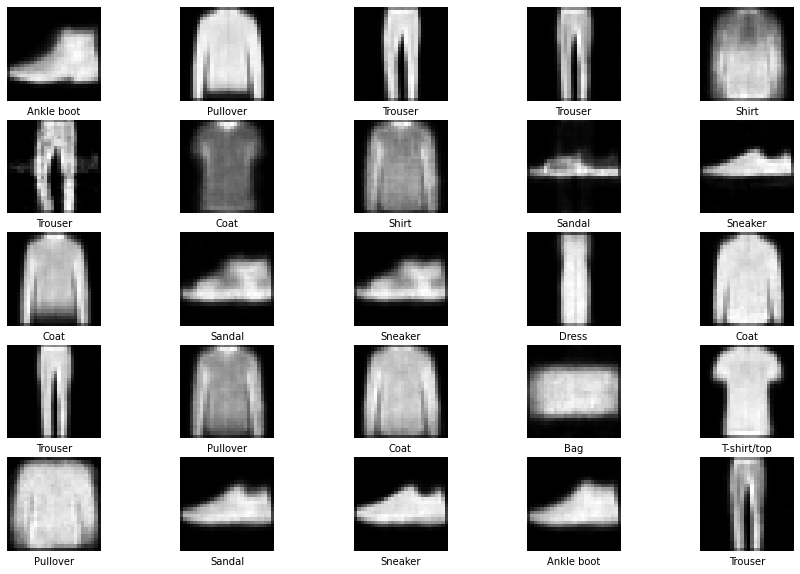

In [28]:
figsize = 15

m, v = enc.predict(x_test[:25])
latent = sample([m,v])
reconst = dec.predict(latent)

fig = plt.figure(figsize=(figsize, 10))

for i in range(25):
    ax = fig.add_subplot(5, 5, i+1)
    ax.axis('off')
    ax.text(0.5, -0.15, str(label_dict[y_test[i]]), fontsize=10, ha='center', transform=ax.transAxes)
    
    ax.imshow(reconst[i, :,:,0]*255, cmap = 'gray')

# Sample new images

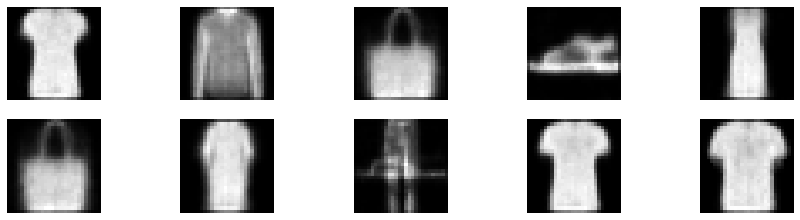

In [29]:
figsize = 15

x = np.random.normal(size = (10,2))
#x = np.random.uniform(size = (10,200))
reconstruct = dec.predict(x)


fig = plt.figure(figsize=(figsize, 10))

for i in range(10):
    ax = fig.add_subplot(5, 5, i+1)
    ax.axis('off')
    ax.imshow(reconstruct[i, :,:,0]*255, cmap = 'gray')

# Latent Space Projection of Variational Autoencoder Trained on Fashion-MNIST

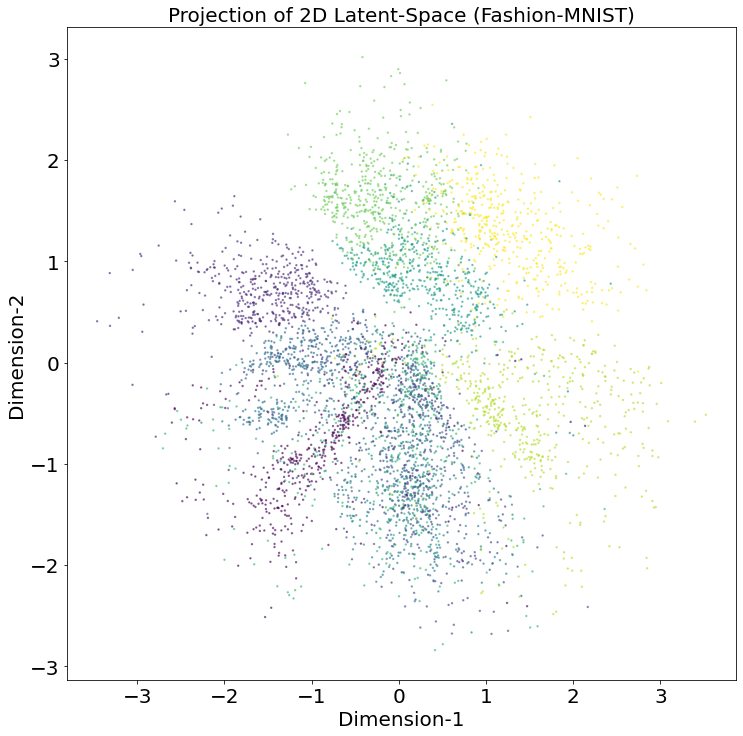

In [32]:
n_to_show = 5000
figsize = 12

example_idx = np.random.choice(range(len(x_test)), n_to_show)
example_images = x_test[example_idx]
labels = y_test[example_idx]

m, v = enc.predict(example_images)
embeddings = sample([m,v])



plt.figure(figsize=(figsize, figsize))
plt.scatter(embeddings[:, 0] , embeddings[:, 1], alpha=0.5, s=2, c=labels)
plt.xlabel("Dimension-1", size=20)
plt.ylabel("Dimension-2", size=20)
plt.xticks(size=20)
plt.yticks(size=20)
plt.title("Projection of 2D Latent-Space (Fashion-MNIST)", size=20)
plt.show()

# Reconstructing Fashion Images with Latent-Vector Sampled Uniformly

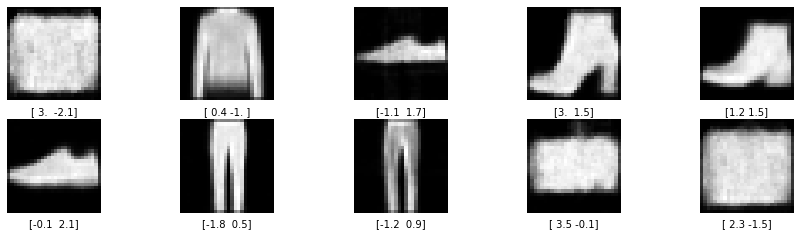

In [33]:
figsize = 15

min_x = min(embeddings[:, 0])
max_x = max(embeddings[:, 0])
min_y = min(embeddings[:, 1])
max_y = max(embeddings[:, 1])


x = np.random.uniform(min_x,max_x, size = (10,1))
y = np.random.uniform(min_y,max_y, size = (10,1))
z_grid = np.concatenate((x,y), axis=1)
reconst = dec.predict(z_grid)


fig = plt.figure(figsize=(figsize, 10))

for i in range(10):
    ax = fig.add_subplot(5, 5, i+1)
    ax.axis('off')
    ax.text(0.5, -0.15, str(np.round(z_grid[i],1)), fontsize=10, ha='center', transform=ax.transAxes)
    
    ax.imshow(reconst[i, :,:,0]*255, cmap = 'gray')